# Задача: построить модель, которая за первые 3 дня позволит предсказать, дропнется ли пользователь с курса

### Информация о данных

Два датасета представляют из себя информацию о пользователях-студентах курса статистики за 3 года на Степик. 
- data_events содержит информацию о дате и типе действия юзера 
- data_submissions -информацию о пользователе, дате сабмита и и значении сабмита: true/ false

## Этапы работы


- #### Общий обзор данных, первичная предподготовка
- #### Разметка данных
    ##### Target переменная: получил ли сертификат (certificated)
        - Курс считается законченным, если пользователь набрал больше 170 баллов
    
    ##### Вспомогательная переменная для того, чтобы не включать  "Юзеров "в пути" из тренировочного датасета (churn_out)

        - Эта переменная позволяет отделить юзеров, которые ещё проходят курс, от юзеров, которые уже забросили курс. "Юзеры " в пути" не нужны в тренировочном датасете. Churn_out вычислялась через среднее время перерывов для каждого успешно прошедшего юзера, конкретно был взят квантиль 0.95, который оказался равен 43 дням. Если юзер не заходит больше 43 дней, он считается ушедшим
   ##### Сам тренировочный датасет состоял из переменных:
     - correct - количество правильно решённых практических заданий
     - wrong - количество неверно решённых практических заданий
     - discovered - количество открытых разделов	
     - passed -	количество пройденных степов
     - started_attempt - количество первых попыток решить задачу
     - viewed - количество просмотренных степов
     *Все переменные были отобраны за 3 первых дня на курсе
- #### Прогнозирование
        - Desicion Tree. Первая обзорная модель, позволяющая оценить важность данных 
        - Random Forest. Второй метод, было построено две модели: одна с со всеми отобранными train фичами и вторая без части фич, показавшихся избыточными после desicion tree: started_attempt, discovered, viewed.
        - logit. Модель с единственной НП - correct.
- ### Результат   
Как оказалось, train датасет получился очень простым с точки зрения важности фич - самой важной оказалась фича correct, отражающая количество правильно выполненных заданий. Из-за этого основные показатели: accuracy, precion, recall, и ROC оказались практически одинаковыми для всех вариантов моделей(accuracy=0.99 для тренировочных и тестовых выборок, ROC = 1). **Тем не менее, самый большой ROC score продемонстрировал Random Forest cо всеми фичами train датасета - ROC score на степике составил 0.799**. Второй rf без фич started_attempt, discovered, viewed и Logit показали меньший ROC score. 

Так что для предсказания успеха пользователей стоит выбрать именно random forest!

## Общий обзор данных, первичная предподготовка

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns


from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn import tree
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import plot_roc_curve
from sklearn.ensemble import RandomForestClassifier

from sklearn.linear_model import LogisticRegressionCV
import statsmodels.api as sm 
import statsmodels.formula.api as sf

import math as m

In [2]:
#задаём стиль графикам
sns.set (
    font_scale =2,
    style = 'whitegrid',
    rc= {'figure.figsize': (30,7)}
)

In [3]:
event_data = pd.read_csv('C:/Users/cbata/stepik_ml_practice/Ml_project/event_data_train.csv')

In [4]:
submissions_data = pd.read_csv('C:/Users/cbata/stepik_ml_practice/Ml_project/submissions_data_train.csv')

## Общий обзор данных:

Далее я просто посмотрю содержимое, нет ли ошибок, пропусков

In [5]:
event_data.head(3)

,step_id,timestamp,action,user_id
0,32815,1434340848,viewed,17632
1,32815,1434340848,passed,17632
2,32815,1434340848,discovered,17632


In [6]:
submissions_data.head(3)

,step_id,timestamp,submission_status,user_id
0,31971,1434349275,correct,15853
1,31972,1434348300,correct,15853
2,31972,1478852149,wrong,15853


In [7]:
print('event_data \n')
print('shape \n', event_data.shape, '\n')
print('Типы колонок \n', event_data.dtypes, '\n')
print('Количество NAN \n',event_data.isna().sum())

event_data 

shape 
 (3480703, 4) 

Типы колонок 
 step_id       int64
timestamp     int64
action       object
user_id       int64
dtype: object 

Количество NAN 
 step_id      0
timestamp    0
action       0
user_id      0
dtype: int64


In [8]:
print('submissions_data \n')
print('shape \n', submissions_data.shape, '\n')
print('Типы колонок \n', submissions_data.dtypes, '\n')
print('Количество NAN \n',submissions_data.isna().sum())

submissions_data 

shape 
 (509104, 4) 

Типы колонок 
 step_id               int64
timestamp             int64
submission_status    object
user_id               int64
dtype: object 

Количество NAN 
 step_id              0
timestamp            0
submission_status    0
user_id              0
dtype: int64


Одна из главных колонок - действие, которой совершил студент. Какие действия доступны?

In [9]:
event_data.action.unique()

array(['viewed', 'passed', 'discovered', 'started_attempt'], dtype=object)

In [10]:
event_data.step_id.nunique()

198

In [11]:
submissions_data.step_id.nunique()

76

В данных есть timestamp, но это не очень удобно. Добавлю новую колонку - дату, чтобы было удобнее.

In [12]:
event_data['date'] = pd.to_datetime(event_data.timestamp, unit = 's').dt.date
submissions_data['date'] = pd.to_datetime(submissions_data.timestamp, unit = 's').dt.date

In [13]:
event_data.head(1)

,step_id,timestamp,action,user_id,date
0,32815,1434340848,viewed,17632,2015-06-15


In [14]:
submissions_data.head(1)

,step_id,timestamp,submission_status,user_id,date
0,31971,1434349275,correct,15853,2015-06-15


Какие временные рамки датасетов?

In [147]:
print('event_data ', event_data.date.min(), '-',event_data.date.max() )

event_data  2015-06-15 - 2018-05-19


In [148]:
print('submissions_data ',submissions_data.date.min(), '-',submissions_data.date.max() )

submissions_data  2015-06-15 - 2018-05-19


Одинаково ли количество юзеров в обоих датасетах?

In [17]:
submissions_data.user_id.nunique() 

9940

In [18]:
event_data.user_id.nunique() 

19234

Как мы видим, пользователей, которые просто зашли на курс, почти в 2 раза больше тех, кто что-то решал, что не противоречиво

Имеет смысл посмотреть самые общие вещи: распределение уникальных пользователей по дням, сколько действий совершил каждый студент, каково распределение баллов, сколько человек закончили курс. Курс считается законченным, если пользователь набрал больше 170 баллов

Text(0.5, 1.0, 'Распределение уникальных пользователей по дням')

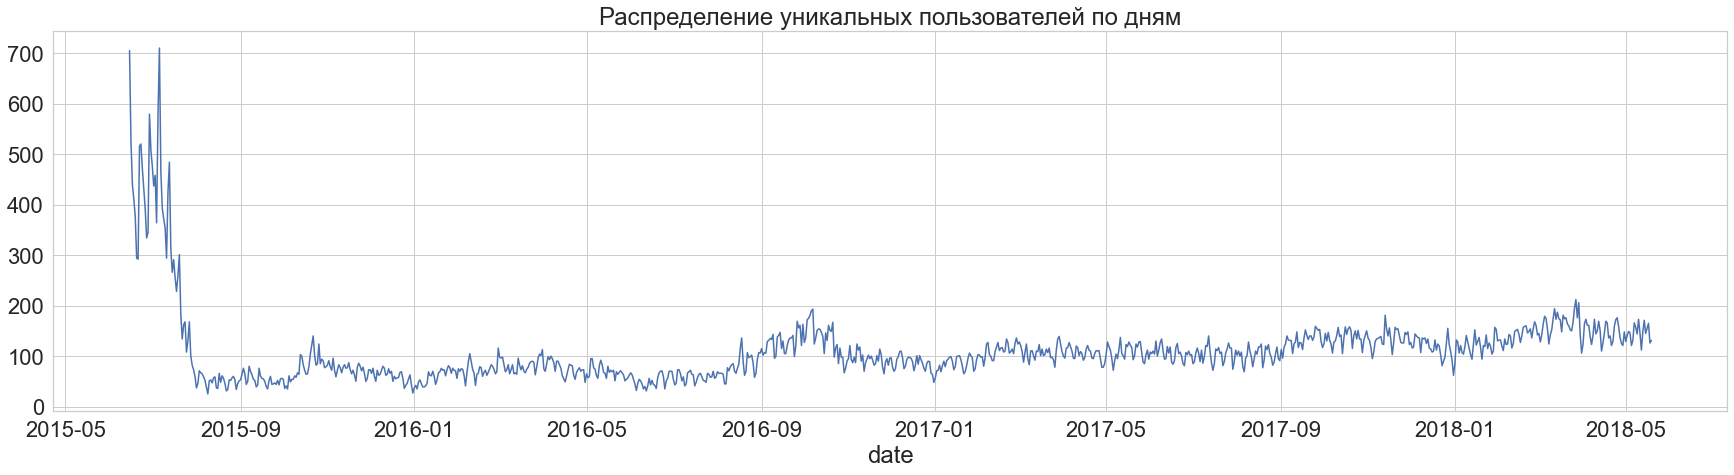

In [19]:
event_data.groupby('date').user_id.nunique().plot()
plt.title('Распределение уникальных пользователей по дням')

В момент запуска курс был достаточно популярен, но за 3 месяца количество уникальных пользователей снизилось с 700 до приблизительно 50. Тем не менее, спустя 2 года интерес к курсу начал расти, и в среднем заходить на курс стали по 100 человек в день 

Сколько действий совершил каждый студент? Каково распределение баллов? Сколько человек закончили курс? 

In [20]:
action_count_by_user = event_data \
    .pivot_table(index='user_id', columns = 'action', values = 'step_id' ,aggfunc= 'count', fill_value = 0).reset_index()

In [21]:
action_count_by_user.head(3)

action,user_id,discovered,passed,started_attempt,viewed
0,1,1,0,0,1
1,2,9,9,2,10
2,3,91,87,30,192


Text(0.5, 1.0, 'Распределение баллов')

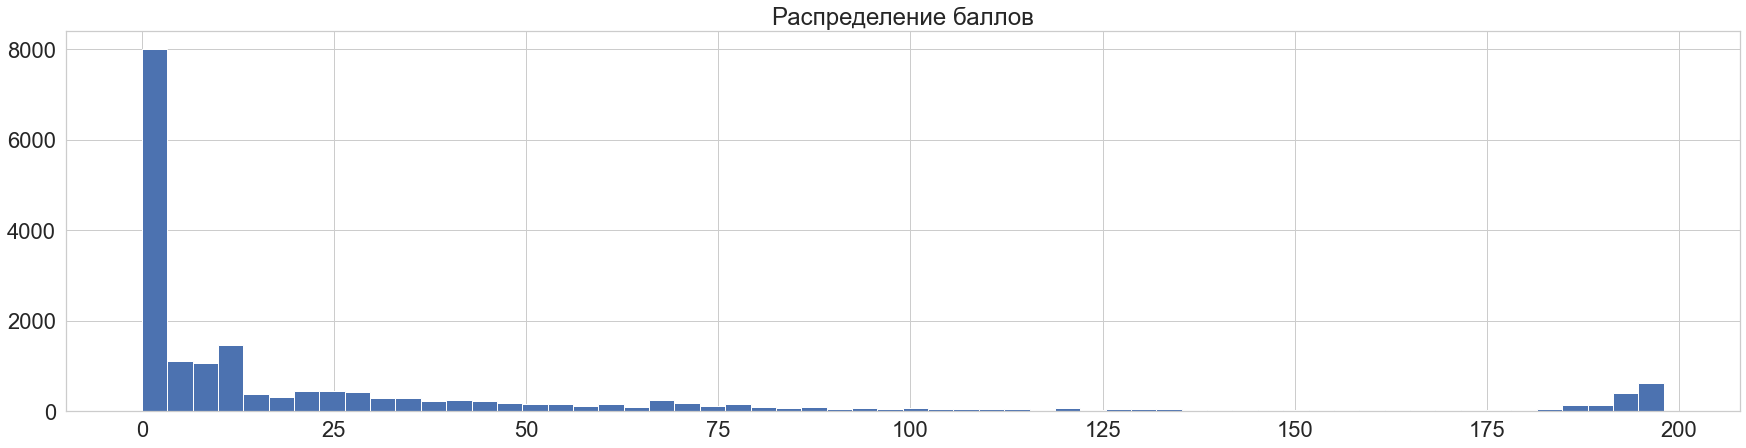

In [22]:
action_count_by_user.passed.hist(bins = 60)
plt.title('Распределение баллов')

Как видно на графике, весьма небольшая доля пользователей прошла курс: практически все отвалились буквально после первых десяти заданий. Подробнее лучше посмотреть через describe:

In [23]:
action_count_by_user.passed.describe()

count    19234.000000
mean        33.811532
std         54.932368
min          0.000000
25%          1.000000
50%          8.000000
75%         39.000000
max        198.000000
Name: passed, dtype: float64

Медиана -  всего 8 баллов, 75% пользователей набрали меньше 38, а четверь - меньше одного балла!

Сколько студентов в итоге закончили курс?

In [24]:
action_count_by_user.query('passed > 170').shape[0]

1425

А в процентах?

In [25]:
round(action_count_by_user.query('passed > 170').shape[0] / action_count_by_user.shape[0] *100 )

7

Итак, мы видимо, что всего 7% студентов прошли курс до конца. Этот датафрейм пригодится далее, потому введём колонку certificated 

In [26]:
action_count_by_user['certificated'] = np.where(action_count_by_user.passed > 170, 1,0)

Проверяю:

In [27]:
action_count_by_user.certificated.sum()

1425

## Разметка данных

Так как мы хотим предсказывать пользователей, которые дропнули курс, также стоит обратить внимание на временные промежутки в решении задач пользователями. Через какое время следует считать пользователя ушедшим? Имеет смысл посчитать промежутки в датах между действиями пользователя, чтобы выявить некий средний показатель. Я решила, что целесообразно будет посчитать его в днях. Тем не менее, для дальнейших вычислений мне понадобится именно timestamp

In [28]:
user_gaps = event_data[['user_id','date', 'timestamp']] \
    .drop_duplicates(subset = ['user_id','date']).sort_values(by = ['user_id','date']) \
    .groupby('user_id')['timestamp'].apply(list).apply(np.diff).to_frame().reset_index()  #перевожу таймстапп в список, чтобы применить diff

In [29]:
user_gaps.head(3)

,user_id,timestamp
0,1,[]
1,2,[4843602]
2,3,"[6899249, 182484, 93710, 2768870, 171400, 78712]"


Теперь нужно вычислить среднее время перерыва для пользователя

In [30]:
user_gaps= user_gaps.explode('timestamp') 

In [31]:
user_gaps.timestamp = user_gaps.timestamp.astype(float) 

Убираю пустые значения, так как они в данном случае не информативны и мешают работать с данными дальше

In [32]:
user_gaps_nan_dropped = user_gaps.groupby('user_id', as_index = False).agg({'timestamp': 'mean'}).dropna() \
    .rename(columns= {'timestamp' : 'timestamp_gape'})

Из timestamp значений перевожу средний перерыв в дни:

In [33]:
user_gaps_nan_dropped['days_gape'] = user_gaps_nan_dropped.timestamp_gape /(60*60*24)

In [34]:
user_gaps_nan_dropped.head()

,user_id,timestamp_gape,days_gape
1,2,4.843602e+06,56.060208
2,3,1.699071e+06,19.665172
3,5,3.370281e+07,390.078843
5,8,8.634840e+05,9.994028
9,16,3.874390e+06,44.842474


Хочу перепроверить себя и проверяю, есть ли days_gape <1, по идее такого быть не должно:

In [35]:
sum(user_gaps_nan_dropped.days_gape <1)

794

Это сбило меня с толку и я решила посмотреть, где закралась ошибка. Проблема вот в чём: дубликаты были дропнуты по дате, тогда как разница таймстамп значений может быть меньше 24 часов. Для того, чтобы наступил новый день, необязательно должно пройти 24 часа с предыдущего. Я решила, что в таком случае стоит округлить значения days_gape, чтобы минимальным значением стал 1 день

In [36]:
user_gaps_nan_dropped['days_gape'] = np.where(user_gaps_nan_dropped.days_gape <1,
                                              np.ceil(user_gaps_nan_dropped.days_gape), round(user_gaps_nan_dropped.days_gape))

In [37]:
user_gaps_nan_dropped.head(3)

,user_id,timestamp_gape,days_gape
1,2,4.843602e+06,56.0
2,3,1.699071e+06,20.0
3,5,3.370281e+07,390.0


Проверим снова, не осталось ли значений меньше одного дня:

In [38]:
sum(round(user_gaps_nan_dropped.days_gape) <1)

0

Отлично, теперь можно посмотреть график распределения и квантили:

Text(0.5, 1.0, 'Распределение перерывов между занятиями')

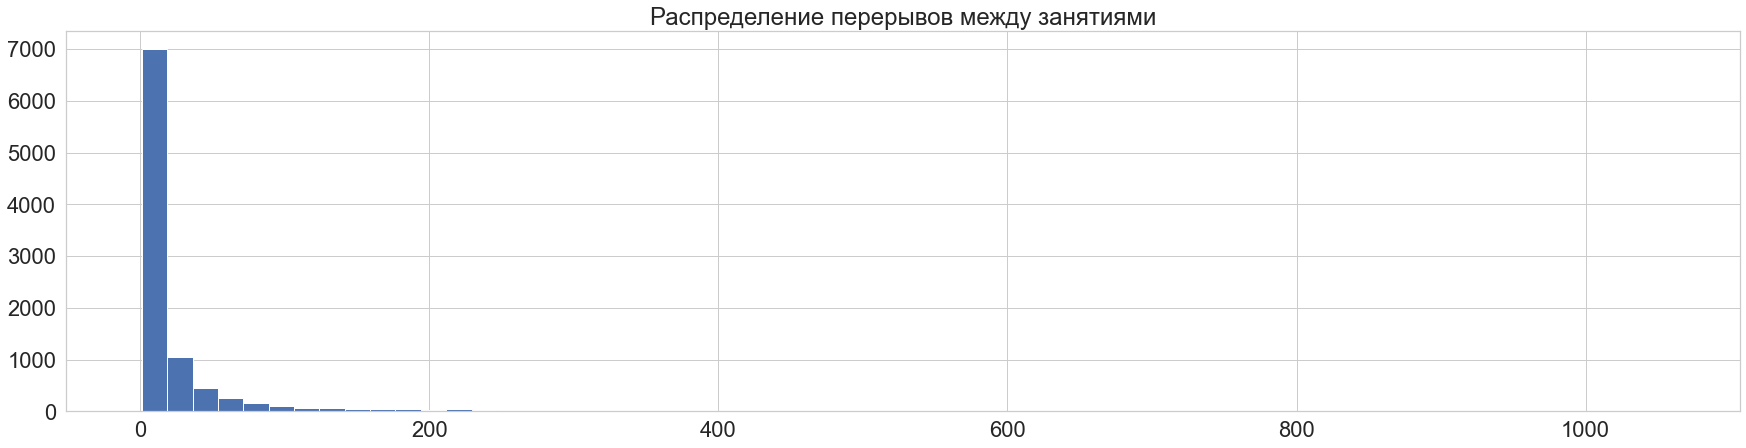

In [39]:
user_gaps_nan_dropped.days_gape.hist(bins = 60)
plt.title('Распределение перерывов между занятиями')

Из-за выбросов график не очень понятно отображает происходящее. Перейдём к квантилям:

In [40]:
user_gaps_nan_dropped.days_gape.describe()

count    9526.000000
mean       25.843376
std        68.760587
min         1.000000
25%         2.000000
50%         6.000000
75%        20.000000
max      1054.000000
Name: days_gape, dtype: float64

Это общие данные по перерывам для всех пользователей. Медианное значение - 6 дней, максимальное - считай что 3 года, минимальное - 1 день.
Так как у нас есть информация о юзерах, уже прошедших курс, следует ориентироваться на перерывы в занятиях именно этих юзеров, так как скорее всего это будет меньший промежуток времени

In [41]:
user_gaps_nan_dropped_certificated = user_gaps_nan_dropped \
    .merge(action_count_by_user[['certificated', 'user_id']], on = 'user_id')

Text(0.5, 1.0, 'Распределение перерывов между занятиями для прошедших и не прошедших курс')

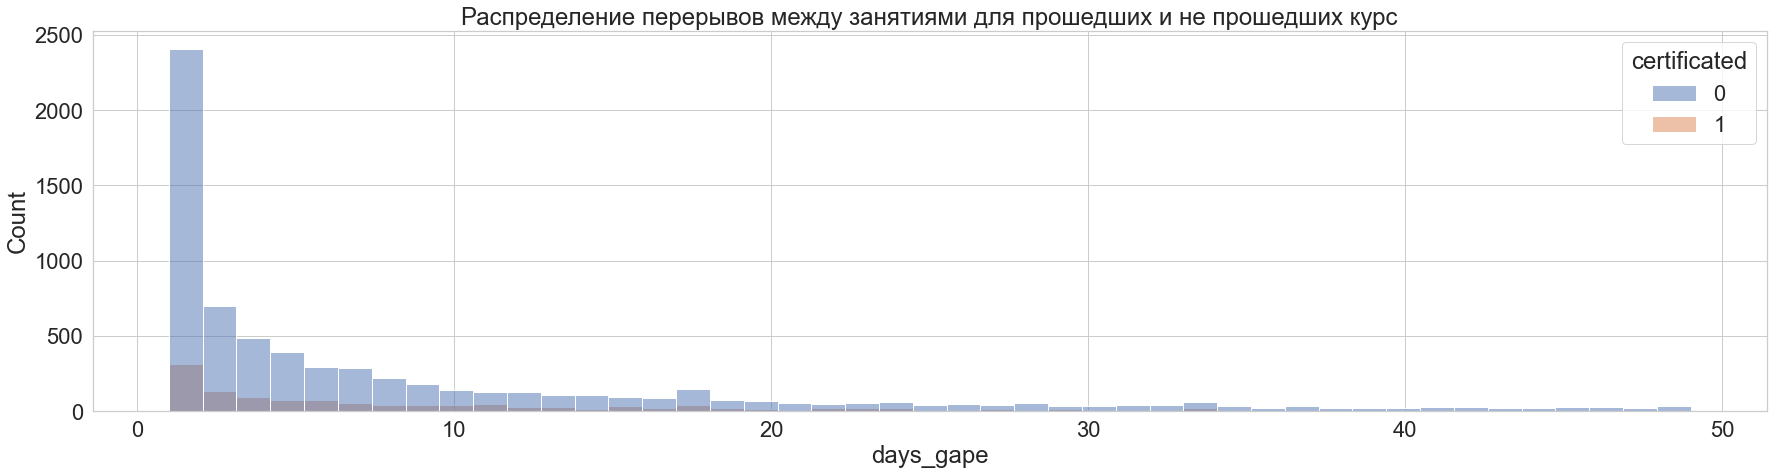

In [42]:
sns.histplot(user_gaps_nan_dropped_certificated.query('days_gape<50'), x ='days_gape', hue = 'certificated')
plt.title('Распределение перерывов между занятиями для прошедших и не прошедших курс')

Перерывы прошедших курс:

In [43]:
user_gaps_nan_dropped_certificated.query('certificated == 1').days_gape.describe()

count    1424.000000
mean       13.154494
std        16.949929
min         1.000000
25%         3.000000
50%         7.000000
75%        17.250000
max       223.000000
Name: days_gape, dtype: float64

Медианное значение - 7 дней, максимальное - считай что 223 дня(выброс), минимальное - 1 день

Text(0.5, 1.0, 'Распределение перерывов между занятиями для прошедших курс')

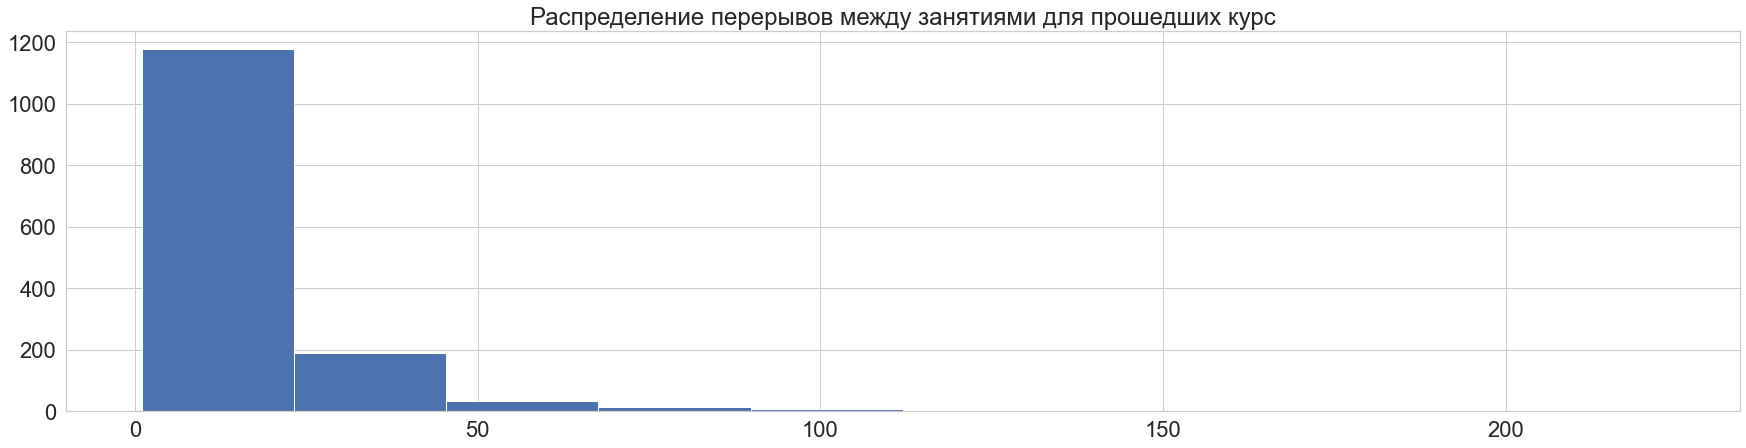

In [44]:
user_gaps_nan_dropped_certificated.query('certificated == 1').days_gape.hist()
plt.title('Распределение перерывов между занятиями для прошедших курс')

По доброй традиции, будем ориентироваться на 95% процентов. 

In [45]:
drop_days = user_gaps_nan_dropped_certificated.query('certificated == 1').days_gape.quantile(q=0.95)

In [46]:
drop_days

43.0

In [47]:
drop_time = drop_days * (60*60*24)

In [48]:
drop_time 

3715200.0

Теперь мы стали ближе к разметке данных по признаку бросил пользователь курс/не бросил. Для того, чтобы пользователь считался ушедшим, условие будет следующим: 
- с последней даты посещения прошло более 43 дней(относительно последней даты в дф - 2018-05-19)
- сертификат не получен. Для этого у нас уже есть датафрейм action_count_by_user 

Сначала вычислим, какие пользователи отсутсвуют слишком долго. Считаем таймстемп последнего дня, вычитаем последний таймстемп пользователя, смотрим, привышает ли разница допустимое значение отсутсвия

In [49]:
last_date = event_data.tail(1).timestamp.values[0] 

In [50]:
last_date

1526772811

In [51]:
users_data = event_data.groupby('user_id', as_index= False).agg({'timestamp': 'max'}) \
    .rename(columns ={'timestamp' : 'last_timestamp'})

In [52]:
users_data.head(3)

,user_id,last_timestamp
0,1,1472827464
1,2,1519226966
2,3,1444581588


In [53]:
users_data['churn_out'] = (last_date - event_data.groupby('user_id', as_index= False) \
                           .agg({'timestamp': 'max'}).timestamp ) > drop_time

In [54]:
users_data.head(3)

,user_id,last_timestamp,churn_out
0,1,1472827464,True
1,2,1519226966,True
2,3,1444581588,True


Теперь у нас есть небольшой дф с информацией о таймстемпе последнего действия и факте слишком долгого отсутсвия. Нужно добавить информацию о том, прошёл пользователь курс или нет - этому соответсвует колонка certificated из action_count_by_user

In [55]:
users_data = users_data.merge(action_count_by_user[['certificated', 'user_id']], how = 'left')

In [56]:
users_data.head(3)

,user_id,last_timestamp,churn_out,certificated
0,1,1472827464,True,0
1,2,1519226966,True,0
2,3,1444581588,True,0


Уберём юзеров " в  пути" - они не сертифицированы, но и отсутсвуют недостаточно долго, чтобы считаться ушедшими

In [57]:
users_data_target = users_data.query('~(churn_out == False and certificated == 0)')

In [58]:
users_data_target.head(3)

,user_id,last_timestamp,churn_out,certificated
0,1,1472827464,True,0
1,2,1519226966,True,0
2,3,1444581588,True,0


Проверка:

In [59]:
users_data_target.query('(churn_out == False and certificated == 0)')

,user_id,last_timestamp,churn_out,certificated


In [60]:
users_data_target.user_id.nunique()

17633

Сколько юзеров в процессе прохождения?

In [61]:
users_data.query('(churn_out == False and certificated == 0)').shape[0] / users_data_target.shape[0]

0.09079566721488119

#### Итак, первая часть предподготовки пройдена: у нас есть список пользователей, о которых нам точно известно, ушли они или прошли курс.

Но для тренировочного датасета этого не хватает. Цель будущей модели - как можно быстрее определить, уйдёт юзер или пройдёт курс. Для этого нам нужно собрать датасет с разными свойствами пользователей за небольшой начальный период времени.

Отберём записи за 3 дня и используем их в качестве train выборки

In [62]:
time_border = 3* 60*60*24

In [63]:
min_timestamp_df = event_data.groupby('user_id', as_index =False) \
    .agg({'timestamp': 'min'}) \
    .rename(columns = {'timestamp' :'min_timestamp'})

In [64]:
min_timestamp_df.head(3)

,user_id,min_timestamp
0,1,1472827464
1,2,1514383364
2,3,1434358476


In [65]:
event_data = event_data.merge(min_timestamp_df, how = 'left')

In [66]:
event_data['time_border_for_user'] = event_data.min_timestamp + time_border

In [67]:
event_data_train = event_data.query('timestamp < time_border_for_user')

In [68]:
event_data_train.head(3)

,step_id,timestamp,action,user_id,date,min_timestamp,time_border_for_user
0,32815,1434340848,viewed,17632,2015-06-15,1434340848,1434600048
1,32815,1434340848,passed,17632,2015-06-15,1434340848,1434600048
2,32815,1434340848,discovered,17632,2015-06-15,1434340848,1434600048


In [69]:
print ('shape', ' :' , event_data_train.shape)
print ('user_id_unique', ' :',  event_data_train.user_id.nunique())

shape  : (1014980, 7)
user_id_unique  : 19234


Осталась только трети записей, все юзеры на месте

То же самое проделываю для дф с сабмитами, они пригодятся для тренировочного датасета:

In [70]:
min_sub_timestamp = event_data.groupby('user_id', as_index =False) \
    .agg({'timestamp': 'min'}) \
    .rename(columns = {'timestamp' :'min_timestamp'})
submissions_data = submissions_data.merge(min_sub_timestamp)
submissions_data ['time_border_for_user'] = submissions_data.min_timestamp + time_border
submissions_data_train = submissions_data.query('timestamp < time_border_for_user')

In [71]:
submissions_data_train.head(3)

,step_id,timestamp,submission_status,user_id,date,min_timestamp,time_border_for_user
0,31971,1434349275,correct,15853,2015-06-15,1434345977,1434605177
1,31972,1434348300,correct,15853,2015-06-15,1434345977,1434605177
4,31976,1434348123,wrong,15853,2015-06-15,1434345977,1434605177


Так как эти данные также нужны нам в посчитанном виде по correct и wrong, считаем, а после соединяем с event_data_train

In [72]:
sub_counted = submissions_data \
    .pivot_table(index = 'user_id', columns = 'submission_status', values = 'step_id', aggfunc = 'count') \
    .reset_index().fillna(0)

In [73]:
sub_counted.head(3)

submission_status,user_id,correct,wrong
0,2,2.0,0.0
1,3,29.0,23.0
2,5,2.0,2.0


In [74]:
event_data_train = event_data_train.merge(sub_counted[['correct', 'wrong', 'user_id']], how= 'left', on = 'user_id' )

In [75]:
event_data_train.head(3)

,step_id,timestamp,action,user_id,date,min_timestamp,time_border_for_user,correct,wrong
0,32815,1434340848,viewed,17632,2015-06-15,1434340848,1434600048,31.0,278.0
1,32815,1434340848,passed,17632,2015-06-15,1434340848,1434600048,31.0,278.0
2,32815,1434340848,discovered,17632,2015-06-15,1434340848,1434600048,31.0,278.0


Проверка:

In [76]:
print ('shape', ' :' , event_data_train.shape)
print ('user_id_unique', ' :',  event_data_train.user_id.nunique())

shape  : (1014980, 9)
user_id_unique  : 19234


Теперь к тренировочному датасету нужно добавить ещё разного всякого: есть ли у юзера сертификат, дропнул ли он курс на текущий момент(если нет, то эти записи нужно убрать), так же не помешает сама разная информация о количестве правильных/неправильных сабмитов, а также конкретных действий вроде просмотра, решения и так далее. А ещё нужно оставить только пользователей, которые точно ушли или точно закончили курс.

Присоединяю churn_out и certificated, оставляю только нужных пользователей:

In [77]:
event_data_train = event_data_train \
    .merge(users_data_target[['churn_out', 'certificated', 'user_id']], how= 'right', on = 'user_id' )

In [78]:
event_data_train.head(3)

,step_id,timestamp,action,user_id,date,min_timestamp,time_border_for_user,correct,wrong,churn_out,certificated
0,31981,1472827464,viewed,1,2016-09-02,1472827464,1473086664,NaN,NaN,True,0
1,31981,1472827464,discovered,1,2016-09-02,1472827464,1473086664,NaN,NaN,True,0
2,32815,1514383364,discovered,2,2017-12-27,1514383364,1514642564,2.0,0.0,True,0


Проверка:

In [79]:
event_data_train.user_id.nunique() == users_data_target.user_id.nunique()

True

In [80]:
print ('shape', ' :' , event_data_train.shape)
print ('user_id_unique', ' :',  event_data_train.user_id.nunique())

shape  : (918315, 11)
user_id_unique  : 17633


In [81]:
event_data_train.timestamp.isna().sum()

0

In [82]:
event_data_train.head(3)

,step_id,timestamp,action,user_id,date,min_timestamp,time_border_for_user,correct,wrong,churn_out,certificated
0,31981,1472827464,viewed,1,2016-09-02,1472827464,1473086664,NaN,NaN,True,0
1,31981,1472827464,discovered,1,2016-09-02,1472827464,1473086664,NaN,NaN,True,0
2,32815,1514383364,discovered,2,2017-12-27,1514383364,1514642564,2.0,0.0,True,0


У сабмитов correct и wrong есть NAN, это значит, пользователь ничего не засабмиттил(соответсвтенно, его не было в сабмит датасете). Заполним такие случаи нулями.

In [83]:
event_data_train.correct = event_data_train.correct.fillna(0)
event_data_train.wrong = event_data_train.wrong.fillna(0)

Теперь присоединяю частоты разных action для пользователя:

In [84]:
event_data_train = event_data_train \
    .merge(event_data_train \
    .pivot_table(index='user_id', columns = 'action', values = 'step_id' ,aggfunc= 'count', fill_value = 0).reset_index()) \
    .drop('action', axis = 1)

In [85]:
event_data_train.head()

,step_id,timestamp,user_id,date,min_timestamp,time_border_for_user,correct,wrong,churn_out,certificated,discovered,passed,started_attempt,viewed
0,31981,1472827464,1,2016-09-02,1472827464,1473086664,0.0,0.0,True,0,1,0,0,1
1,31981,1472827464,1,2016-09-02,1472827464,1473086664,0.0,0.0,True,0,1,0,0,1
2,32815,1514383364,2,2017-12-27,1514383364,1514642564,2.0,0.0,True,0,9,9,2,9
3,32815,1514383364,2,2017-12-27,1514383364,1514642564,2.0,0.0,True,0,9,9,2,9
4,32815,1514383364,2,2017-12-27,1514383364,1514642564,2.0,0.0,True,0,9,9,2,9


Накопилось дублированных юзеров! Убираем

In [86]:
event_data_train = event_data_train.drop_duplicates('user_id')

Ещё раз смотрю, всё ли в порядке:

In [87]:
event_data_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 17633 entries, 0 to 918276
Data columns (total 14 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   step_id               17633 non-null  int64  
 1   timestamp             17633 non-null  int64  
 2   user_id               17633 non-null  int64  
 3   date                  17633 non-null  object 
 4   min_timestamp         17633 non-null  int64  
 5   time_border_for_user  17633 non-null  int64  
 6   correct               17633 non-null  float64
 7   wrong                 17633 non-null  float64
 8   churn_out             17633 non-null  bool   
 9   certificated          17633 non-null  int32  
 10  discovered            17633 non-null  int64  
 11  passed                17633 non-null  int64  
 12  started_attempt       17633 non-null  int64  
 13  viewed                17633 non-null  int64  
dtypes: bool(1), float64(2), int32(1), int64(9), object(1)
memory usage: 1

In [88]:
event_data_train.shape

(17633, 14)

Хорошо. Наконец, настало время для финального тренировочного датасета. В нем останутся колонки:

- correct - количество правильно решённых практических заданий
- wrong - количество неверно решённых практических заданий
- discovered - количество открытых разделов
- passed - количество пройденных степов
- started_attempt - количество первых попыток решить задачу
- viewed - количество просмотренных степов

In [89]:
event_data_train = event_data_train[['user_id', 'correct', 'wrong','discovered','passed','started_attempt','viewed', 'certificated']]

In [90]:
event_data_train  = event_data_train.set_index('user_id')

In [91]:
event_data_train.head()

,correct,wrong,discovered,passed,started_attempt,viewed,certificated
user_id,,,,,,,
1,0.0,0.0,1,0,0,1,0
2,2.0,0.0,9,9,2,9,0
3,29.0,23.0,15,15,4,20,0
5,2.0,2.0,1,1,0,1,0
7,0.0,0.0,1,1,0,1,0


В таких данных наверняка будет дисбаланс классов, посмотрим, какой он

In [92]:
print('Соотношение прошедших к не прошедшим = ',
      event_data_train[event_data_train.certificated== 1].certificated.count() 
      / event_data_train[event_data_train.certificated== 0].certificated.count())  

Соотношение прошедших к не прошедшим =  0.08791954590325765


Похоже не то, что мы получали в начале. Теперь можно перейти к построению моделей!

# Построение моделей: desicion tree, random forest, logit

Разбиение данных на train и test 

In [93]:
X = event_data_train.iloc[:, :-1]

In [94]:
y = event_data_train.iloc[:, -1]

In [95]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42) 

## Прогнозирование с помощью обычного desicion tree

Для начала я прогоню обычное дерево с параметрами, которые задам из общих соображений. Это позволит мне соринетироваться в фичах, можно будет посмотреть дерево, чтобы оценить важность фич.
Учитывая то, что нам доступно 17633 строк, а количество фичей не такой большое, параметры тоже не должны быть большими 

In [96]:
params_tree = {'min_samples_leaf': range(200,501, 100),
          'max_depth': range(3,25,2),
          'min_samples_split': range(500,1001, 100),
           }

Кроссвалидация для поиска лучшего дерева:

In [97]:
search_tree = GridSearchCV(DecisionTreeClassifier(random_state=42), params_tree)

In [98]:
search_tree.fit(X_train, y_train)

GridSearchCV(estimator=DecisionTreeClassifier(random_state=42),
             param_grid={'max_depth': range(3, 25, 2),
                         'min_samples_leaf': range(200, 501, 100),
                         'min_samples_split': range(500, 1001, 100)})

Какие же параметры оказались лучшими?

In [99]:
search_tree.best_estimator_

DecisionTreeClassifier(max_depth=3, min_samples_leaf=200, min_samples_split=500,
                       random_state=42)

Какой был accuracy? 

In [100]:
search_tree.best_score_

0.9948577368883142

Выглядит неплохо. Теперь передадим лучшее дерево в отдельную переменную и предскажем тестовые данные

In [101]:
best_tree = search_tree.best_estimator_

In [102]:
predictions_tree = best_tree.predict(X_test)

In [103]:
predictions_tree

array([0, 0, 0, ..., 0, 0, 0])

Насколько верно были предсказаны значения на тестовой выборке? 

In [104]:
best_tree.score(X_test, y_test)

0.9943297799954638

Выглядит неплохо, результат лишь чуть меньше, чем на тренировочной выборке. 
Теперь стоит посмотреть конкретные значения precision и recall, чтобы оценить, сколько наблюдений было верно определено к положительным, а сколько - к  отрицательным

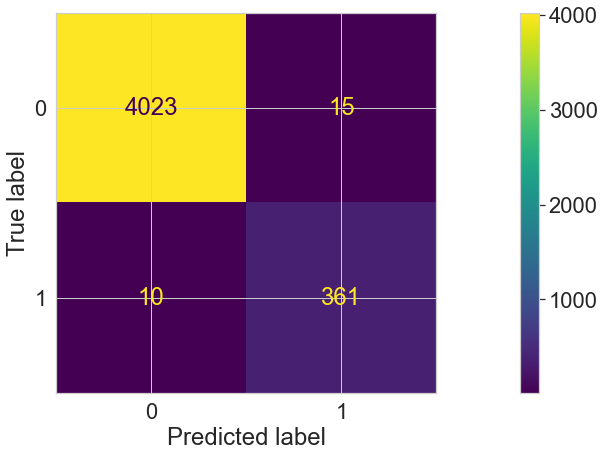

In [105]:
plot_confusion_matrix(best_tree, X_test, y_test)

In [106]:
report_tree = classification_report(y_test, predictions_tree)
print(report_tree)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      4038
           1       0.96      0.97      0.97       371

    accuracy                           0.99      4409
   macro avg       0.98      0.98      0.98      4409
weighted avg       0.99      0.99      0.99      4409



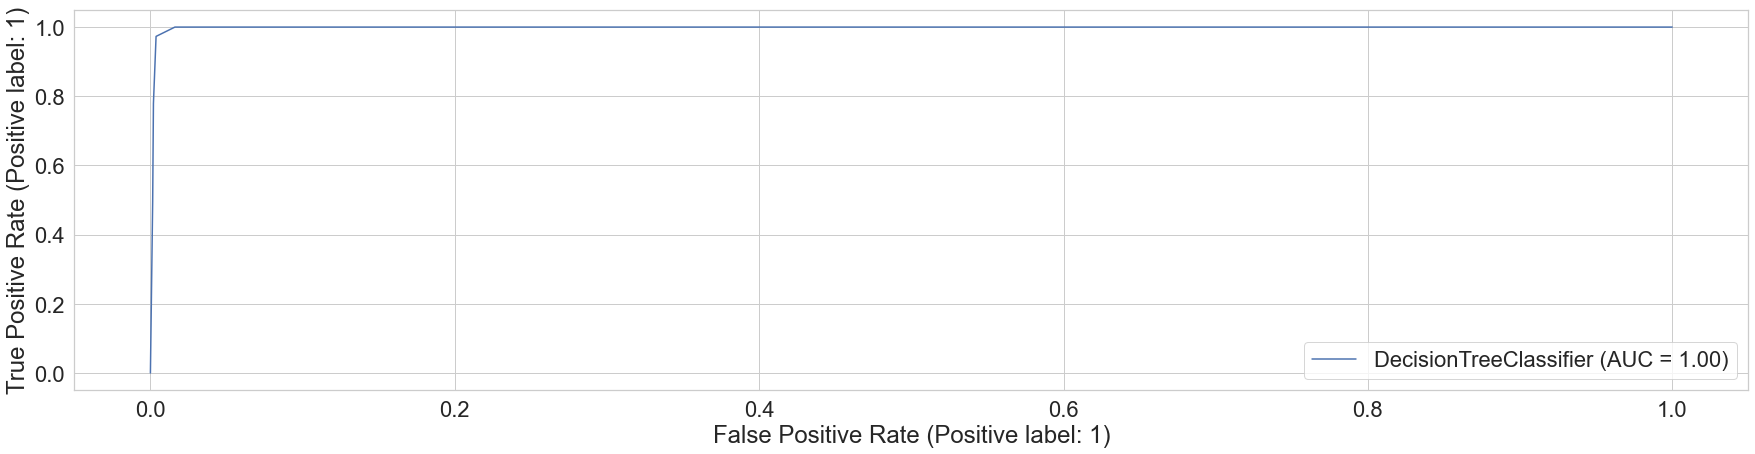

In [107]:
plot_roc_curve(best_tree, X_test, y_test) 

Результат выглядит достаточно высоким, так что в ручном выборе порога нет необходимости.

Как выглядит само дерево?

[Text(744.0, 332.955, 'correct <= 64.5\ngini = 0.147\nsamples = 13224\nvalue = [12170, 1054]'),
 Text(372.0, 237.825, 'correct <= 47.5\ngini = 0.002\nsamples = 12132\nvalue = [12117, 15]'),
 Text(186.0, 142.695, 'gini = 0.0\nsamples = 11926\nvalue = [11926, 0]'),
 Text(558.0, 142.695, 'gini = 0.135\nsamples = 206\nvalue = [191, 15]'),
 Text(1116.0, 237.825, 'correct <= 73.5\ngini = 0.092\nsamples = 1092\nvalue = [53, 1039]'),
 Text(930.0, 142.695, 'gini = 0.289\nsamples = 228\nvalue = [40, 188]'),
 Text(1302.0, 142.695, 'passed <= 22.5\ngini = 0.03\nsamples = 864\nvalue = [13, 851]'),
 Text(1116.0, 47.565, 'gini = 0.05\nsamples = 274\nvalue = [7, 267]'),
 Text(1488.0, 47.565, 'gini = 0.02\nsamples = 590\nvalue = [6, 584]')]

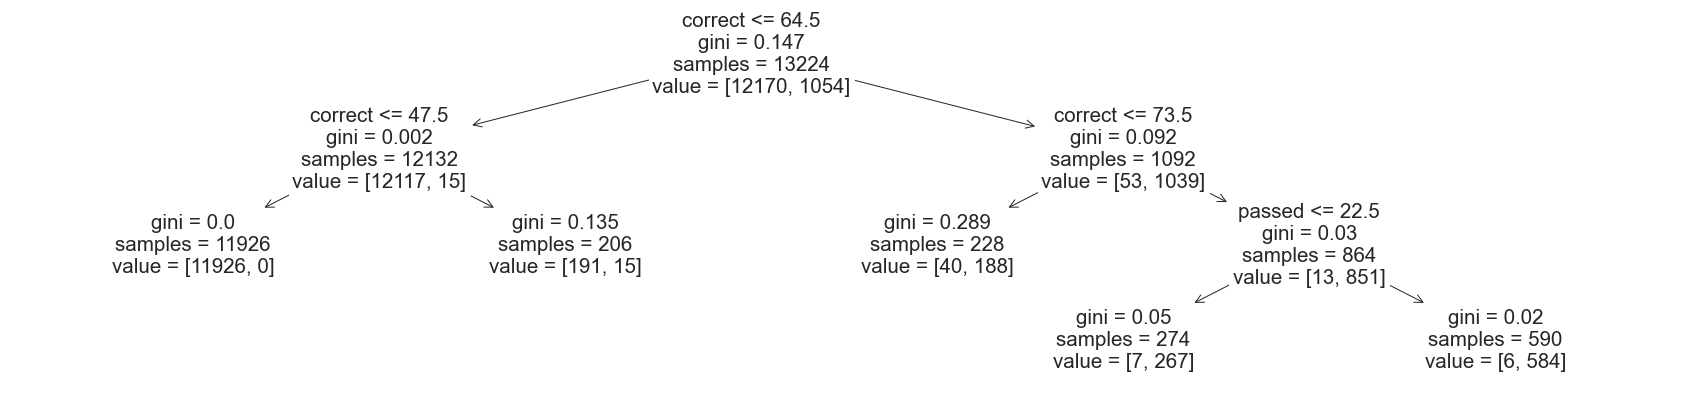

In [108]:
tree.plot_tree(best_tree, feature_names = X.columns)

Дерево выглядит внятным и оказалось на деле довольно простым: видно, что основную роль в предсказании certificated играет переменная correct - количество верных ответов, и только на третьем шаге дерево обращается к переменной passed в одном из узлов. 

#### Вывод по classification tree: 
Полученная модель выглядит достаточно хорошей, ROC AUC = 1, accuracy = 0.99. Интепретация простая - дерево преимущественно путешествует по переменной correct. Дерево получилось неглубоким, максимальная глубина - 3. Accuracy score в тренировочном датасете и в тестовом примерно равны, визуально дерево небольшое

## Прогнозирование с помощью random forest

Параметры для random forest стоит подбирать не такими большими, как для обычного desicion tree

In [109]:
params_forest = {
    'n_estimators' : [10,20, 30],
    'min_samples_leaf': [10, 20],
    'max_depth': range(1,20),
    'min_samples_split': [40, 50],
           }

In [110]:
search_forest = GridSearchCV(RandomForestClassifier(random_state=42), params_forest)

In [111]:
search_forest.fit(X_train, y_train)

GridSearchCV(estimator=RandomForestClassifier(random_state=42),
             param_grid={'max_depth': range(1, 20),
                         'min_samples_leaf': [10, 20],
                         'min_samples_split': [40, 50],
                         'n_estimators': [10, 20, 30]})

In [112]:
best_forest = search_forest.best_estimator_

Параметры лучшего леса:

In [113]:
best_forest

RandomForestClassifier(max_depth=2, min_samples_leaf=10, min_samples_split=40,
                       n_estimators=20, random_state=42)

Предсказание значений тестовой выборки:

In [114]:
predictions_forest = best_forest.predict(X_test)

In [115]:
predictions_forest

array([0, 0, 0, ..., 0, 0, 0])

Значения accuracy, precision, recall и ROC AUC:

In [116]:
print('accuracy_score: ', best_forest.score(X_test, y_test))

accuracy_score:  0.9943297799954638


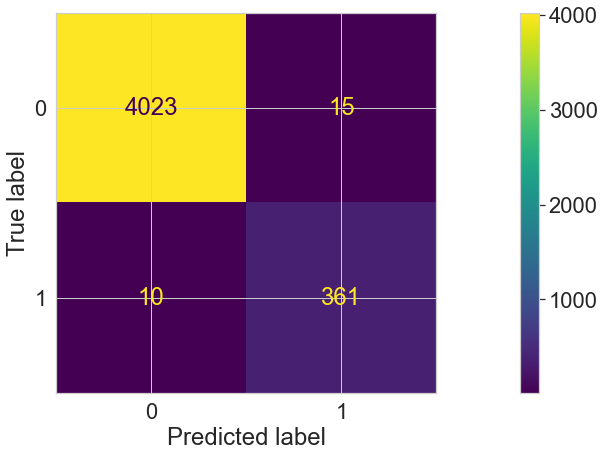

In [117]:
plot_confusion_matrix(best_forest, X_test, y_test)

In [118]:
report_forest = classification_report(y_test, predictions_forest)
print(report_forest)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      4038
           1       0.96      0.97      0.97       371

    accuracy                           0.99      4409
   macro avg       0.98      0.98      0.98      4409
weighted avg       0.99      0.99      0.99      4409



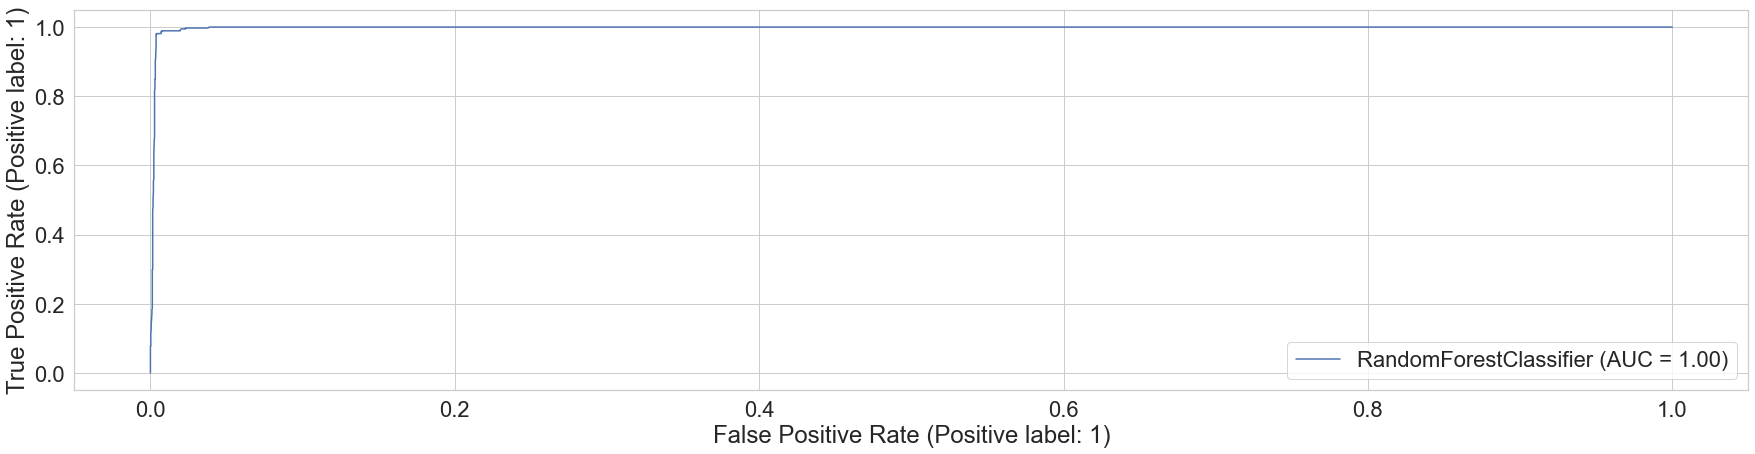

In [119]:
plot_roc_curve(best_forest, X_test, y_test) 

Какие фичи оказались самыми значимыми для прогноза леса?

Text(0.5, 1.0, 'Самые значимые фичи для модели')

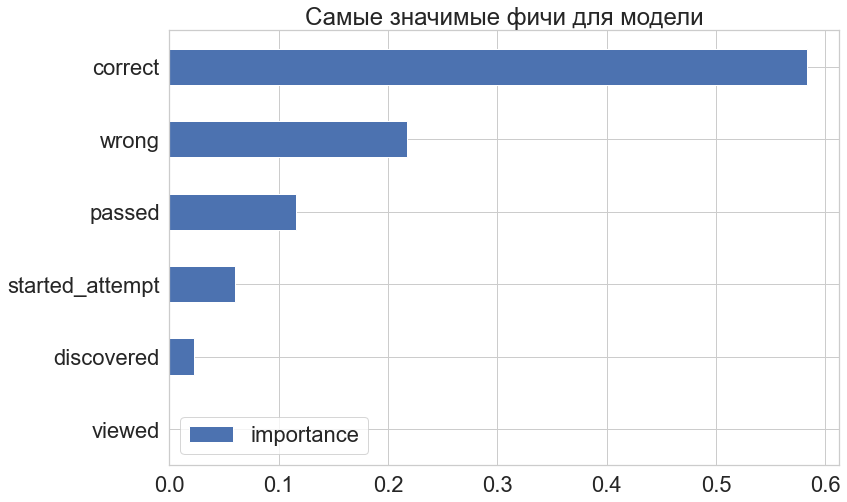

In [120]:
imp = pd.DataFrame(best_forest.feature_importances_, index=X.columns, columns=['importance'])
imp.sort_values('importance').plot(kind='barh', figsize=(12, 8))
plt.title('Самые значимые фичи для модели')

In [121]:
feature_importances_df = pd.DataFrame({'features':list(X_train.columns), 
                                       'feature_importances':  best_forest.feature_importances_})\
                        .sort_values(by='feature_importances', ascending = False)

In [122]:
feature_importances_df

,features,feature_importances
0,correct,0.583144
1,wrong,0.217628
3,passed,0.116287
4,started_attempt,0.059915
2,discovered,0.023005
5,viewed,0.000021



ъЗначения вероятности отнесения к классам для каждого наблюдения

In [123]:
y_prob = best_forest.predict_proba(X)

In [124]:
y_prob_0 = y_prob[:, 0]

In [125]:
y_prob_1= y_prob[:, 1]

In [126]:
print(
'Вероятность отнесения к нулевому классу для каждого наблюдения. В нашем случае - вероятность, что человек уйдёт с курса:','\n',
    y_prob_0)

Вероятность отнесения к нулевому классу для каждого наблюдения. В нашем случае - вероятность, что человек уйдёт с курса: 
 [0.99442936 0.98097721 0.98097721 ... 0.91053853 0.98097721 0.98097721]


In [127]:
print(
'Вероятность отнесения к первому классу для каждого наблюдения. В нашем случае - вероятность, что человек закончит курс :','\n',
    y_prob_1)

Вероятность отнесения к первому классу для каждого наблюдения. В нашем случае - вероятность, что человек закончит курс : 
 [0.00557064 0.01902279 0.01902279 ... 0.08946147 0.01902279 0.01902279]


Здесь следует сказать, что я делала **ещё одну random forest модель** без фич started_attempt, discovered, viewed, так как они согласно прошлым двум моделям они не выглядят значимыми. Тем не менее, такая обновлённая модель получила ROC score всего лишь 0.612, и я убрала её, чтобы не делать текуший код более нагруженным.

#### Вывод по random forest: 
Как и в случае с desicion tree, ROC AUC = 1, accuracy = 0.99. Такие похожие результаты могут быть связаны с простотой данных - как выяснилось, фича correct хорошо описывает target. Accuracy score в тренировочном датасете и в тестовом примерно равны. 
#### Тем не менее, ROC score на степике для этого леса составил лишь 0.799


### Прогнозирование с помощью logit

Вернёмся к нашему исходному датафрейму event_data_train:

In [128]:
event_data_train.head()

,correct,wrong,discovered,passed,started_attempt,viewed,certificated
user_id,,,,,,,
1,0.0,0.0,1,0,0,1,0
2,2.0,0.0,9,9,2,9,0
3,29.0,23.0,15,15,4,20,0
5,2.0,2.0,1,1,0,1,0
7,0.0,0.0,1,1,0,1,0


Logit, в отличие от деревьев, менее устойчив к мультиколлинеарности. Стоит построить корреляционную матрицу

<AxesSubplot:>

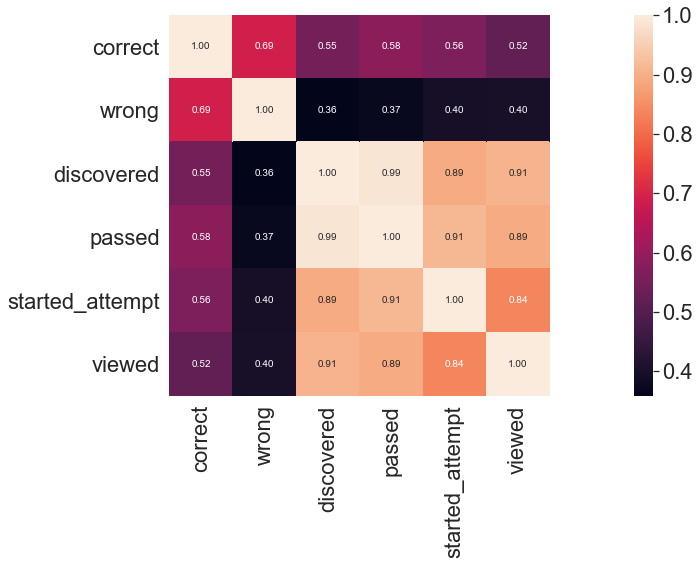

In [129]:
cols = event_data_train.columns[:-1]
cm = np.corrcoef(event_data_train[cols].values.T)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values)
hm 

Как видно, и это косвенно было известно из предыдущих моделей, correct является связующей переменной. discovered,viewed, started attempt высоко коррелируют между собой, и согласно предыдущим моделям, не сильно влияют на прогнозирование. Их стоит просто убрать. 
**Correct и wrong** также сильно коррелируют между собой: судя по всему, кто больше старается, у того и получается! Судя по всему, для logit имеет смысл оставить только колонку **correct**

In [130]:
logit_train = event_data_train[['correct', 'certificated']]

In [131]:
logit_train.head(3)

,correct,certificated
user_id,,
1,0.0,0
2,2.0,0
3,29.0,0


Построение модели:

In [132]:
X_logit = logit_train.correct

In [133]:
y_logit = logit_train.certificated

In [134]:
X_train_logit, X_test_logit, y_train_logit, y_test_logit = train_test_split(X_logit, y_logit, test_size=0.25, random_state=42) 

In [135]:
logit = LogisticRegressionCV(random_state=42)

In [136]:
logit_model = logit.fit(X_train_logit.values.reshape(-1, 1), y_train_logit)

accuracy для тренировочных данных:

In [137]:
logit_model.score(X_train_logit.values.reshape(-1, 1), y_train_logit)

0.9948578342407743

Описание модели подробнее через statsmodel:

In [141]:
logit_res = sf.glm('certificated ~ correct', logit_train, family = sm.families.Binomial()).fit()

In [142]:
logit_res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:           certificated   No. Observations:                17633
Model:                            GLM   Df Residuals:                    17631
Model Family:                Binomial   Df Model:                            1
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -293.45
Date:                Sun, 31 Jul 2022   Deviance:                       586.91
Time:                        15:59:28   Pearson chi2:                 4.26e+03
No. Iterations:                    12                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    -20.3960      1.147    -17.788      0.000     -22.643     -18.149
correct        0.3192      0.017     19.046      0.000       0.286       0.352
==============================================================================
"""

Отдельно записываем коэф и сами вероятности

In [228]:
logit_params={}

In [229]:
for i in range(len(logit_res.params.index)):
    prob= m.exp(logit_res.params[i]) / (1+ m.exp(logit_res.params[i]))
    logit_params[(logit_res.params.index[i])] = [logit_res.params[i], prob]

In [242]:
pd.DataFrame.from_dict(logit_params, orient = 'index', columns = ['coef', 'prob'])

,coef,prob
Intercept,-20.39604,1.387115e-09
correct,0.31916,5.791196e-01


Как и ожидалось, переменная correct статистически значима. Вероятность, что юзер с нулевым количеством правильных ответов пройдёт курс, стремится к нулю. С каждым баллом correct вероятность увеличивается.

Предсказания:

In [138]:
predictions_logit = logit_model.predict(X_test_logit.values.reshape(-1, 1))

In [139]:
logit_model.predict_proba(X_test_logit.values.reshape(-1, 1))

array([[9.86198794e-01, 1.38012057e-02],
       [9.99985215e-01, 1.47848174e-05],
       [1.00000000e+00, 2.55866900e-10],
       ...,
       [1.00000000e+00, 2.55866900e-10],
       [9.99999999e-01, 1.41920996e-09],
       [1.00000000e+00, 2.55866900e-10]])

accuracy для тестовых данных:

In [140]:
logit_model.score(X_test_logit.values.reshape(-1, 1), y_test)

0.9943297799954638

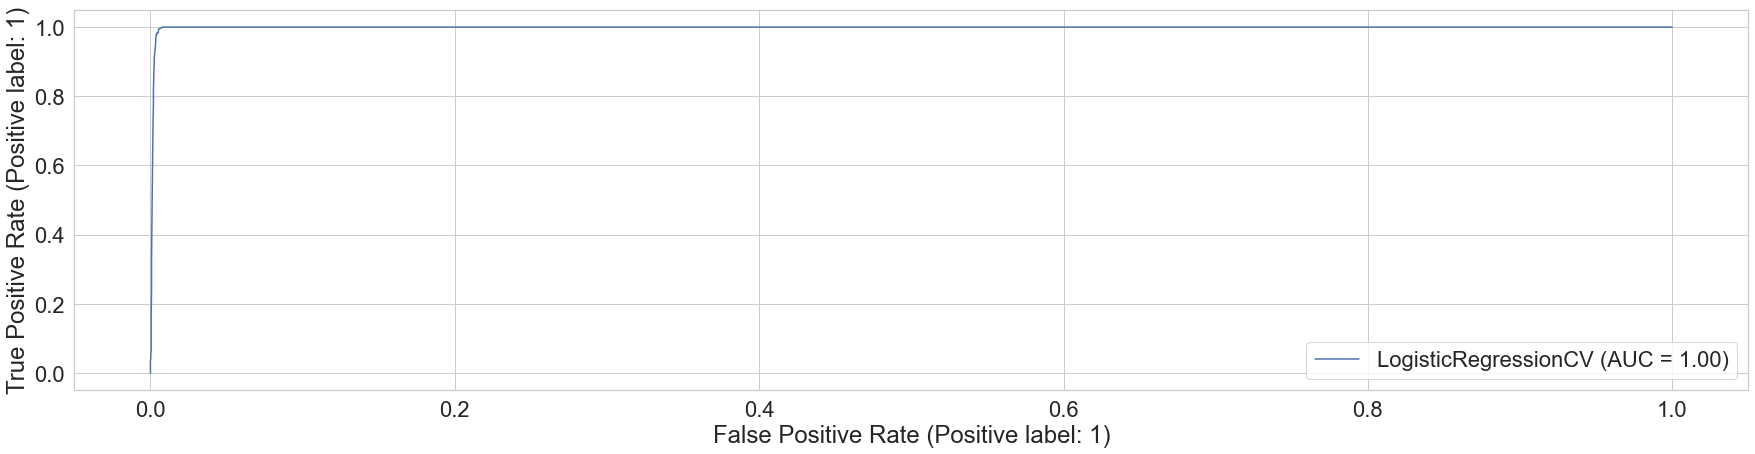

In [260]:
plot_roc_curve(logit_model, X_test_logit.values.reshape(-1, 1), y_test_logit) 

#### Вывод по logit: 

Кажется, в данном случае logit ничем не уступает лесу. Accuracy и ROC score одинаковы. Но при проверке через степик эта модель выдала ROC score, меньший, чем лес, так что её стоит отбросить.

### Результат по моделям   
Как оказалось, train датасет получился очень простым с точки зрения важности фич - самой важной оказалась фича correct, отражающая количество правильно выполненных заданий. Из-за этого основные показатели: accuracy, precion, recall, и ROC оказались практически одинаковыми для всех вариантов моделей(accuracy=0.99 для тренировочных и тестовых выборок, ROC = 1). **Тем не менее, самый большой ROC score продемонстрировал Random Forest cо всеми фичами train датасета - ROC score на степике составил 0.799**. Второй rf без фич started_attempt, discovered, viewed и Logit показали меньший ROC score. 

Так что для предсказания успеха пользователей стоит выбрать именно random forest!